<a href="https://colab.research.google.com/github/joaopcnogueira/colab-notebooks/blob/main/Time_Series_Multi_Step_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Referência**: 

1. [How to Predict Multiple Time Series with Scikit-Learn with Sales Forecasting](https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/)
2. [How to Use Neural Networks to Forecast Multiple Steps of a Time Series](https://www.mariofilho.com/how-to-use-neural-networks-to-forecast-multiple-steps-of-time-series/)
3. [How to Develop Multi-Output Regression Models with Python](https://machinelearningmastery.com/multi-output-regression-models-with-python/)

In [1]:
import numpy as np
import pandas as pd
import os

In [104]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Sales_Transactions_Dataset_Weekly.csv')

data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,...,Normalized 12,Normalized 13,Normalized 14,Normalized 15,Normalized 16,Normalized 17,Normalized 18,Normalized 19,Normalized 20,Normalized 21,Normalized 22,Normalized 23,Normalized 24,Normalized 25,Normalized 26,Normalized 27,Normalized 28,Normalized 29,Normalized 30,Normalized 31,Normalized 32,Normalized 33,Normalized 34,Normalized 35,Normalized 36,Normalized 37,Normalized 38,Normalized 39,Normalized 40,Normalized 41,Normalized 42,Normalized 43,Normalized 44,Normalized 45,Normalized 46,Normalized 47,Normalized 48,Normalized 49,Normalized 50,Normalized 51
0,P1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,...,0.72,0.33,0.33,0.33,0.61,0.33,0.00,0.50,0.11,0.44,0.22,0.50,0.11,0.33,0.22,0.39,0.11,0.44,0.22,0.39,0.50,0.17,0.11,0.61,0.39,0.33,0.50,0.78,0.22,0.44,0.06,0.22,0.28,0.39,0.50,0.00,0.22,0.17,0.11,0.39
1,P2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,...,0.60,0.20,0.00,0.60,0.20,0.70,0.70,0.90,0.40,0.70,0.20,0.40,0.50,0.30,0.50,0.80,0.50,0.50,0.30,0.10,0.30,0.20,0.30,1.00,0.50,0.20,0.70,0.30,0.20,0.50,0.20,0.40,0.50,0.10,0.10,0.40,0.50,0.10,0.60,0.00
2,P3,7,11,8,9,10,8,7,13,12,6,14,9,4,7,12,8,7,11,10,7,7,13,11,8,10,8,14,5,3,13,11,9,7,8,7,9,6,12,12,...,0.09,0.36,0.82,0.45,0.36,0.73,0.64,0.36,0.36,0.91,0.73,0.45,0.64,0.45,1.00,0.18,0.00,0.91,0.73,0.55,0.36,0.45,0.36,0.55,0.27,0.82,0.82,0.55,0.00,0.18,0.27,1.00,0.18,0.18,0.36,0.45,1.00,0.45,0.45,0.36
3,P4,12,8,13,5,9,6,9,13,13,11,8,4,5,4,15,7,11,9,15,4,6,7,11,7,9,6,10,10,2,6,7,2,5,12,5,19,8,6,8,...,0.18,0.12,0.76,0.29,0.53,0.41,0.76,0.12,0.24,0.29,0.53,0.29,0.41,0.24,0.47,0.47,0.00,0.24,0.29,0.00,0.18,0.59,0.18,1.00,0.35,0.24,0.35,0.35,0.59,0.24,0.41,0.47,0.06,0.12,0.24,0.35,0.71,0.35,0.29,0.35
4,P5,8,5,13,11,6,7,9,14,9,9,11,18,8,4,13,8,10,15,6,13,11,6,10,9,8,12,8,9,13,3,5,3,5,5,9,7,4,8,8,...,0.33,0.07,0.67,0.33,0.47,0.80,0.20,0.67,0.53,0.20,0.47,0.40,0.33,0.60,0.33,0.40,0.67,0.00,0.13,0.00,0.13,0.13,0.40,0.27,0.07,0.33,0.33,0.13,0.13,0.33,0.27,0.53,0.27,0.60,0.20,0.20,0.13,0.53,0.33,0.40


In [105]:
data['Product_Code'].nunique()

811

O dataset consiste de quantidade de vendas semanais para cada um dos produtos 811 produtos.

In [106]:
data = data.filter(regex="Product|W").copy()
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,17,7,11,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,3,2,5,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,6,14,9,4,7,12,8,7,11,10,7,7,13,11,8,10,8,14,5,3,13,11,9,7,8,7,9,6,12,12,9,3,5,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,11,8,4,5,4,15,7,11,9,15,4,6,7,11,7,9,6,10,10,2,6,7,2,5,12,5,19,8,6,8,8,12,6,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,9,11,18,8,4,13,8,10,15,6,13,11,6,10,9,8,12,8,9,13,3,5,3,5,5,9,7,4,8,8,5,5,8,7,11,7,12,6,6,5,11,8,9


In [107]:
data['Product_Code_NUM'] = data['Product_Code'].str.extract("(\d+)").astype(int)
data.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10,W11,W12,W13,W14,W15,W16,W17,W18,W19,W20,W21,W22,W23,W24,W25,W26,W27,W28,W29,W30,W31,W32,W33,W34,W35,W36,W37,W38,W39,W40,W41,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51,Product_Code_NUM
0,P1,11,12,10,8,13,12,14,21,6,14,11,14,16,9,9,9,14,9,3,12,5,11,7,12,5,9,7,10,5,11,7,10,12,6,5,14,10,9,12,17,7,11,4,7,8,10,12,3,7,6,5,10,1
1,P2,7,6,3,2,7,1,6,3,3,3,2,2,6,2,0,6,2,7,7,9,4,7,2,4,5,3,5,8,5,5,3,1,3,2,3,10,5,2,7,3,2,5,2,4,5,1,1,4,5,1,6,0,2
2,P3,7,11,8,9,10,8,7,13,12,6,14,9,4,7,12,8,7,11,10,7,7,13,11,8,10,8,14,5,3,13,11,9,7,8,7,9,6,12,12,9,3,5,6,14,5,5,7,8,14,8,8,7,3
3,P4,12,8,13,5,9,6,9,13,13,11,8,4,5,4,15,7,11,9,15,4,6,7,11,7,9,6,10,10,2,6,7,2,5,12,5,19,8,6,8,8,12,6,9,10,3,4,6,8,14,8,7,8,4
4,P5,8,5,13,11,6,7,9,14,9,9,11,18,8,4,13,8,10,15,6,13,11,6,10,9,8,12,8,9,13,3,5,3,5,5,9,7,4,8,8,5,5,8,7,11,7,12,6,6,5,11,8,9,5


In [108]:
print("Max Product_Code: {} - Unique Product_Code: {}".format(data['Product_Code_NUM'].max(), data['Product_Code_NUM'].nunique()))

Max Product_Code: 819 - Unique Product_Code: 811


# Data Transformation

Preparando os dados e criando os datasets de Treino e Teste.

In [137]:
X_train = []
y_train = []

X_test = []
y_test = []

for ix, row in data.iterrows():
    for w in range(8, 50):
        
        X = row.iloc[w-7:w].values.astype(int)
        y = row.iloc[w:w+3].values.astype(int)

        product_code = row['Product_Code_NUM']
        X = np.append(product_code, X)

        if w < 30:
            X_train.append(X)
            y_train.append(y)
        else:
            X_test.append(X)
            y_test.append(y)


# Finalizando a criação dos datasets
X_cols = ['product_code', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7']
y_cols = ['w8', 'w9', 'w10']

X_train = pd.DataFrame(X_train, columns=X_cols)
y_train = pd.DataFrame(y_train, columns=y_cols)

X_test = pd.DataFrame(X_test, columns=X_cols)
y_test = pd.DataFrame(y_test, columns=y_cols)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17842, 8), (16220, 8), (17842, 3), (16220, 3))

In [139]:
X_train.head()

,product_code,w1,w2,w3,w4,w5,w6,w7
0,1,11,12,10,8,13,12,14
1,1,12,10,8,13,12,14,21
2,1,10,8,13,12,14,21,6
3,1,8,13,12,14,21,6,14
4,1,13,12,14,21,6,14,11


In [140]:
y_train.head()

,w8,w9,w10
0,21,6,14
1,6,14,11
2,14,11,14
3,11,14,16
4,14,16,9


In [161]:
pd.concat([X_train, y_train], axis=1).head() \
  .style.apply(lambda col: ['color:white; background-color: green' for value in col.values], subset=['w8', 'w9', 'w10'])

,product_code,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10
0,1,11,12,10,8,13,12,14,21,6,14
1,1,12,10,8,13,12,14,21,6,14,11
2,1,10,8,13,12,14,21,6,14,11,14
3,1,8,13,12,14,21,6,14,11,14,16
4,1,13,12,14,21,6,14,11,14,16,9


O dataset final mostrado acima tem a seguinte estrutura:

Para cada produto, no caso acima temos evidenciado o P1, utilizamos dados históricos de **7 semanas** (w1, w1, ..., w7) para prever as próximas **3 semanas** (w8, w9 e w10). O nosso target, representando nas colunas em verde, é composto de 3 colunas com cada coluna representando um valor de quantidade vendida do produto na semana específica.

# Random Forest

In [142]:
X_train.head()

,product_code,w1,w2,w3,w4,w5,w6,w7
0,1,11,12,10,8,13,12,14
1,1,12,10,8,13,12,14,21
2,1,10,8,13,12,14,21,6
3,1,8,13,12,14,21,6,14
4,1,13,12,14,21,6,14,11


In [143]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train.drop('product_code', axis=1), y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [145]:
rf_predictions = rf.predict(X_test.drop('product_code', axis=1))

In [146]:
X_test.shape, y_test.shape, rf_predictions.shape

((16220, 8), (16220, 3), (16220, 3))

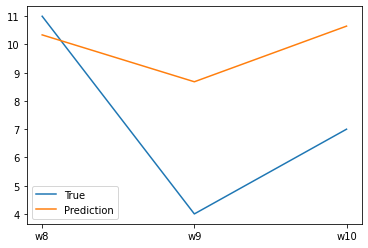

In [150]:
import matplotlib.pyplot as plt

idx = 12
plt.plot(['w8', 'w9', 'w10'], y_test.iloc[idx].values, label='True')
plt.plot(['w8', 'w9', 'w10'], rf_predictions[idx], label='Prediction')
plt.legend();

In [151]:
# RMSLE for each week
np.sqrt(((np.log1p(rf_predictions) - np.log1p(y_test))**2)).mean(axis=0)

w8     0.315735
w9     0.318598
w10    0.317974
dtype: float64

# LightGBM

LGBM por padrão não tem predição com target com multioutput. Temos então que utilizar a classe `MultiOutputRegressor` do scikit-learn para adaptá-lo.

In [153]:
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor

lgbm = MultiOutputRegressor(LGBMRegressor())
lgbm.fit(X_train.drop('product_code', axis=1), y_train)

MultiOutputRegressor(estimator=LGBMRegressor(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=-1,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             random_state=None, reg_alpha=0.0,
                                             reg_lambda=0.0, silent=True,
                                             subsample=1.0,
                                             subsample_for_bin=200000,
                   

In [155]:
lgbm_predictions = lgbm.predict(X_test.drop('product_code', axis=1))

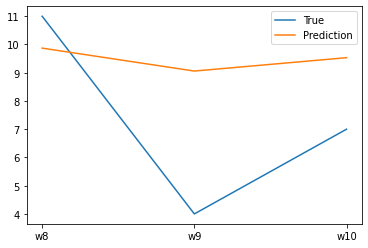

In [156]:
idx = 12
plt.plot(['w8', 'w9', 'w10'], y_test.iloc[idx].values, label='True')
plt.plot(['w8', 'w9', 'w10'], lgbm_predictions[idx], label='Prediction')
plt.legend();

In [157]:
# RMSLE for each week
np.sqrt(((np.log1p(lgbm_predictions) - np.log1p(y_test))**2)).mean(axis=0)

w8     0.310410
w9     0.312479
w10    0.314021
dtype: float64